In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import random
from sklearn.model_selection import train_test_split

def create_img_dset(fp, label):
    dset = []
    for file in os.listdir(fp):
        curr_fp = fp + f'/{file}'
        img = cv2.imread(curr_fp)

        dset.append((img, label))
    
    return dset

b_train = create_img_dset('./b_train', 0)
b_test = create_img_dset('./b_test', 0)
v_files = create_img_dset('./v_files_preprocessed/', 1)

b_train_labels = [0 for i in range(len(b_train))]
b_test_labels = [0 for i in range(len(b_test))]

dataset = np.array(b_train + b_test + v_files[:len(b_train) + len(b_test) - 2])

X_train, X_test, y_train, y_test = train_test_split(dataset[:, 0], dataset[:, 1], test_size=0.2, random_state=42)

C:\Users\Student\AppData\Local\Temp\ipykernel_15332\1019094648.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(b_train + b_test + v_files[:len(b_train) + len(b_test) - 2])


(array([793., 805.]),
 array([0.0, 0.5, 1.0], dtype=object),
 <BarContainer object of 2 artists>)

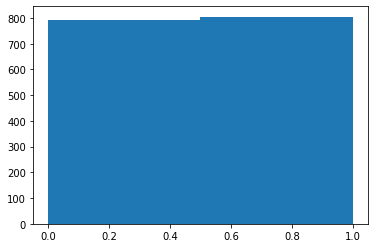

In [3]:
plt.hist(y_train, bins=2)

(array([207., 193.]),
 array([0.0, 0.5, 1.0], dtype=object),
 <BarContainer object of 2 artists>)

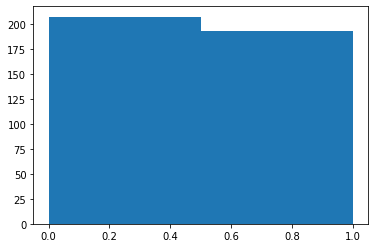

In [4]:
plt.hist(y_test, bins=2)

[1. 0. 0. ... 0. 0. 0.]


(array([6.43e+02, 5.80e+01, 6.30e+01, 9.50e+01, 1.22e+02, 1.29e+03,
        1.93e+02, 3.90e+01, 1.80e+01, 1.60e+01, 1.80e+01, 1.00e+00,
        0.00e+00, 1.00e+00, 3.50e+01]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 15 artists>)

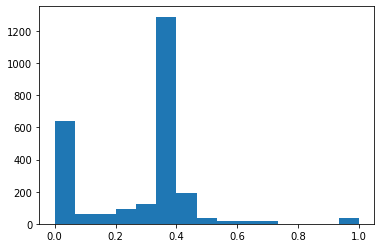

In [5]:
# Histogram of Gradients Feature Extraction
from skimage.feature import hog
from skimage import data, exposure

img = b_train[500][0]
# plt.imshow(img)

def get_hog(img: np.ndarray):
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    hog_image_rescaled = exposure.rescale_intensity(hog_image) #, in_range(0, 10))

    return fd

fd = get_hog(img)
print(fd)

plt.hist(fd, bins=15)

# plt.imshow(hog_image_rescaled)
# plt.imshow(hog_image)

In [6]:
nxtrain = []
nxtest = []

def preprocess_dat(arr: list) -> np.ndarray:
    new_arr = []

    for i in range(len(arr)):
        new_arr.append(get_hog(img))
    
    return np.array(new_arr)

nxtrain = preprocess_dat(X_train)
nxtest = preprocess_dat(X_test)

In [7]:
print(nxtrain[100].shape)
print(nxtest[100])

(2592,)
[1. 0. 0. ... 0. 0. 0.]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2592, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = F.relu(self.l1(x))

        x = F.relu(self.l2(x))

        x = F.relu(self.l3(x))

        return torch.sigmoid(x)

In [19]:
import torch.optim as optim

model = nn.Linear(2592, 1)# MLP()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

losses = []

for epoch in range(100):
    closs = 0
    for i in range(len(nxtrain)):
        X = torch.Tensor(nxtrain[i])
        y = torch.Tensor([y_train[i]])

        pred = model(X)

        loss = criterion(torch.clamp(torch.sigmoid(pred), min=0, max=1), y)

        closs += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(closs/len(nxtrain))
    print(f"[ Epoch {epoch} Loss {losses[-1]} ]")

[ Epoch 0 Loss 0.6944791900276094 ]
[ Epoch 1 Loss 0.694494555269523 ]
[ Epoch 2 Loss 0.6944945561274122 ]
[ Epoch 3 Loss 0.6944945568734027 ]
[ Epoch 4 Loss 0.6944945556798178 ]
[ Epoch 5 Loss 0.6944945567615041 ]
[ Epoch 6 Loss 0.6944945571344994 ]
[ Epoch 7 Loss 0.6944945576939923 ]
[ Epoch 8 Loss 0.6944945561274122 ]
[ Epoch 9 Loss 0.6944945571344994 ]
[ Epoch 10 Loss 0.6944945569107023 ]
[ Epoch 11 Loss 0.6944945575820937 ]
[ Epoch 12 Loss 0.6944945543743344 ]
[ Epoch 13 Loss 0.694494555269523 ]
[ Epoch 14 Loss 0.6944945569480018 ]
[ Epoch 15 Loss 0.6944945554187212 ]
[ Epoch 16 Loss 0.6944945570226008 ]
[ Epoch 17 Loss 0.6944945584772824 ]
[ Epoch 18 Loss 0.6944945566496056 ]
[ Epoch 19 Loss 0.6944945566869051 ]
[ Epoch 20 Loss 0.6944945553441221 ]
[ Epoch 21 Loss 0.6944945574328956 ]
[ Epoch 22 Loss 0.6944945578058909 ]
[ Epoch 23 Loss 0.6944945556425183 ]
[ Epoch 24 Loss 0.6944945581788862 ]
[ Epoch 25 Loss 0.694494554560832 ]
[ Epoch 26 Loss 0.6944945591859734 ]
[ Epoch 27 Los

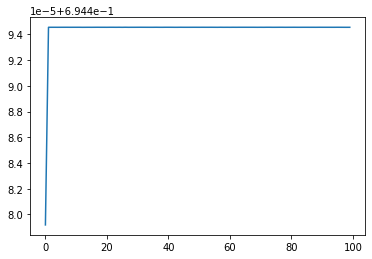

In [20]:
plt.plot(losses)

In [22]:
from sklearn import svm

classifier = svm.SVC()
classifier.fit(nxtrain, y_train.astype(np.uint8))
y_pred = classifier.predict(nxtest)

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 

y_acc = y_test.astype(np.uint8)
# y_pred = np.array(y_pred).astype(np.uint8)

cmat = confusion_matrix(y_acc, y_pred)
print(cmat)
print(accuracy_score(y_acc, y_pred))

[[  0 207]
 [  0 193]]
0.4825


Accuracy: 48.25%
Sensitivity/Recall: nan
Specificity/Precision: 0.4825
F1 Score: nan
AUC Score: 0.5


C:\Users\Student\AppData\Local\Temp\ipykernel_15332\2905447554.py:55: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP/(TP+FN)


[Text(0.5, 1.0, '\nCNN Confusion Matrix\n')]

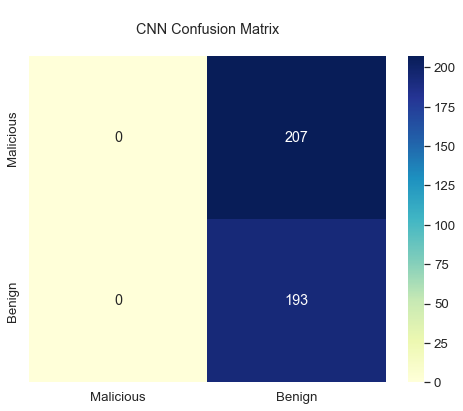

: 

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_auc_score 

inline_rc = dict(mpl.rcParams)

df_cm = pd.DataFrame(cmat, index=["Malicious", "Benign"], columns = ["Malicious", "Benign"])

# plt.figure()
# plt.imshow(cmat, interpolation='nearest', cmap=plt.cm.Blues)
# tick_marks = np.arange(2)
# classNames = ["Malicious", "Benign"]

# # thresh = confusion_matrix.max() / 2.
# for i in range(cmat.shape[0]):
#     for j in range(cmat.shape[1]):
#         plt.text(j, i, format(cmat[i, j]), 
#         ha='center', va='center', 
#         color='white' if cmat[i, j] > 100 else "black")

# plt.tight_layout()
# plt.colorbar()
# plt.show()
plt.figure(figsize=(8, 6))
# sn.heatmap(df_cm, annot=True, cmap='YlGnBu')# , cmap="blue")
sn.set(font_scale=1.2)
# sn.set(font="Verdana")

'''
y_pred = []

for i in range(len(nxtest)):
    arr = nxtest[i]

    arr = [arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]]

    pred = model(torch.Tensor(arr))

    pred = pred.cpu().detach().numpy()[0]

    y_pred.append(pred)

y_b_pred = (np.array(y_pred) > 0.5)*1
'''
y_b_pred = (np.array(y_pred) > 0.5)*1

TP = cmat[0, 0]
FP = cmat[0, 1]
FN = cmat[1, 0]
TN = cmat[1, 1]

# what proportion of positive class was correclty classified
recall = TP/(TP+FN)
# what proportion of negative class was correctly classified
precision = TN/(TN+FP)

f1_score = 2*(precision*recall)/(precision+recall) 

auc = roc_auc_score(y_test.astype(np.uint8), y_pred)

print(f"Accuracy: {accuracy_score(y_acc, y_b_pred) * 100}%")
print(f"Sensitivity/Recall: {round(recall, 4)}")
print(f"Specificity/Precision: {round(precision, 4)}")
print(f"F1 Score: {round(f1_score, 4)}")
print(f"AUC Score: {round(auc, 4)}")

sn.heatmap(df_cm, annot=True, cmap='YlGnBu', fmt='d').set(title='\nCNN Confusion Matrix\n')

Text(0, 0.5, 'True Positive Rate')

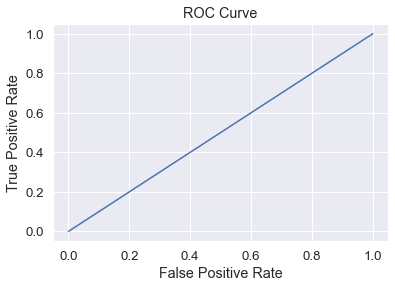

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 

fpr, tpr, thresholds = roc_curve(y_test.astype(np.uint8), y_pred) 

plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')